In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!source /content/drive/MyDrive/colab_env/bin/activate;

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/colab_env/lib/python3.10/site-packages')

In [ ]:
#%pip install -r '/content/drive/MyDrive/Colab_env_initialisation_code/requirements.txt'

In [ ]:
#%pip install stable_baselines3
#%pip install gym_trading_env

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from stable_baselines3 import PPO, DQN, TD3, DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

from stable_baselines3.common.vec_env import DummyVecEnv
import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output
import time

In [ ]:
!cp "/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/history.py" .
!cp "/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/portfolio.py" .
!cp "/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/data_processor.py" .
!cp "/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/environments.py" .

In [ ]:
import datetime
import glob
from pathlib import Path

from collections import Counter
from history import History
from portfolio import Portfolio, TargetPortfolio

import gymnasium as gym
from gymnasium import spaces
import gymnasium
import gym_trading_env

import tempfile, os

In [ ]:
import data_processor
import environments

In [ ]:
gu_daily_path = "/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/data/GBPUSD=X daily.csv"
gu_weekly_path = "/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/data/GBPUSD=X weekly.csv"
gu_monthly_path = "/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/data/GBPUSD=X monthly.csv"

dxy_daily_path = "/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/data/DX-Y.NYB daily.csv"

In [ ]:
Data = data_processor.data_func(gu_daily_path, gu_weekly_path, gu_monthly_path, dxy_daily_path, daily_only=False)

In [ ]:
len(Data)

6

In [ ]:
GU_daily = Data[0]
DXY_daily = Data[3]
merged_gu = Data[4]
merged_df = Data[-1]

### EDA

In [ ]:
GU_daily

,open,high,low,close,day,week,month,year
date,,,,,,,,
2004-01-01,1.788813,1.788813,1.781705,1.785204,4,1,1,2004
2004-01-02,1.785587,1.795010,1.779201,1.793690,5,1,1,2004
2004-01-05,1.795493,1.810315,1.795107,1.807207,1,2,1,2004
2004-01-06,1.807403,1.827786,1.805510,1.821295,2,2,1,2004
2004-01-07,1.820897,1.825584,1.812711,1.817785,3,2,1,2004
...,...,...,...,...,...,...,...,...
2023-12-25,1.267700,1.274665,1.267700,1.267700,1,52,12,2023
2023-12-26,1.270487,1.271941,1.268553,1.270487,2,52,12,2023
2023-12-27,1.272831,1.280115,1.270051,1.272718,3,52,12,2023


<Axes: xlabel='date', ylabel='close'>

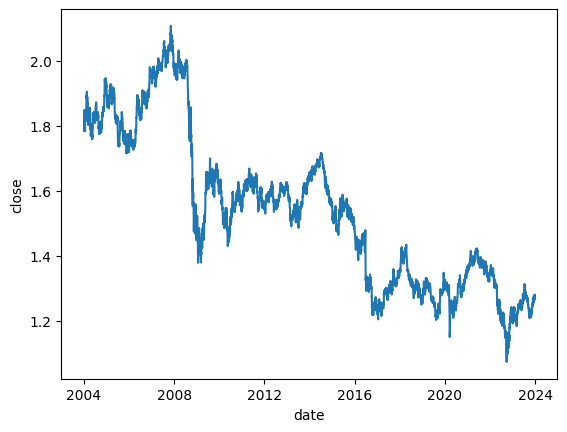

In [ ]:
sns.lineplot(x=GU_daily.index, y=GU_daily['close'])

<Axes: xlabel='date', ylabel='close'>

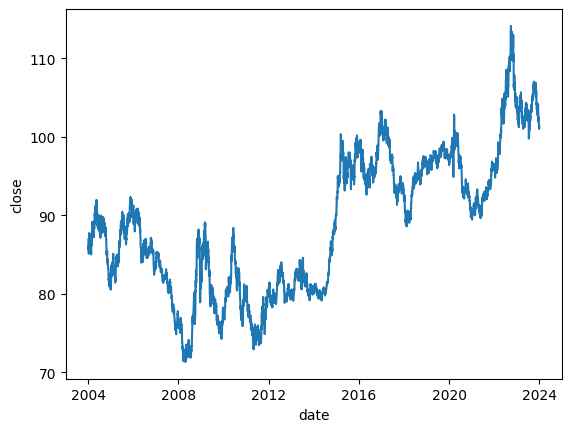

In [ ]:
sns.lineplot(x=DXY_daily.index, y=DXY_daily['close'])

#### Indicator feature engineering

In [ ]:
df = GU_daily.copy()

In [ ]:
#Moving averages
df['EMA_9'] = df['close'].ewm(span=9, adjust=False).mean()
df['EMA_12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['close'].ewm(span=26, adjust=False).mean()

df.bfill(inplace=True)

In [ ]:
df.head(5)

,open,high,low,close,day,week,month,year,EMA_9,EMA_12,EMA_26
date,,,,,,,,,,,
2004-01-01,1.788813,1.788813,1.781705,1.785204,4,1,1,2004,1.785204,1.785204,1.785204
2004-01-02,1.785587,1.795010,1.779201,1.793690,5,1,1,2004,1.786901,1.786510,1.785833
2004-01-05,1.795493,1.810315,1.795107,1.807207,1,2,1,2004,1.790962,1.789694,1.787416
2004-01-06,1.807403,1.827786,1.805510,1.821295,2,2,1,2004,1.797029,1.794555,1.789925
2004-01-07,1.820897,1.825584,1.812711,1.817785,3,2,1,2004,1.801180,1.798129,1.791989


<Axes: xlabel='date', ylabel='feature_EMA_12'>

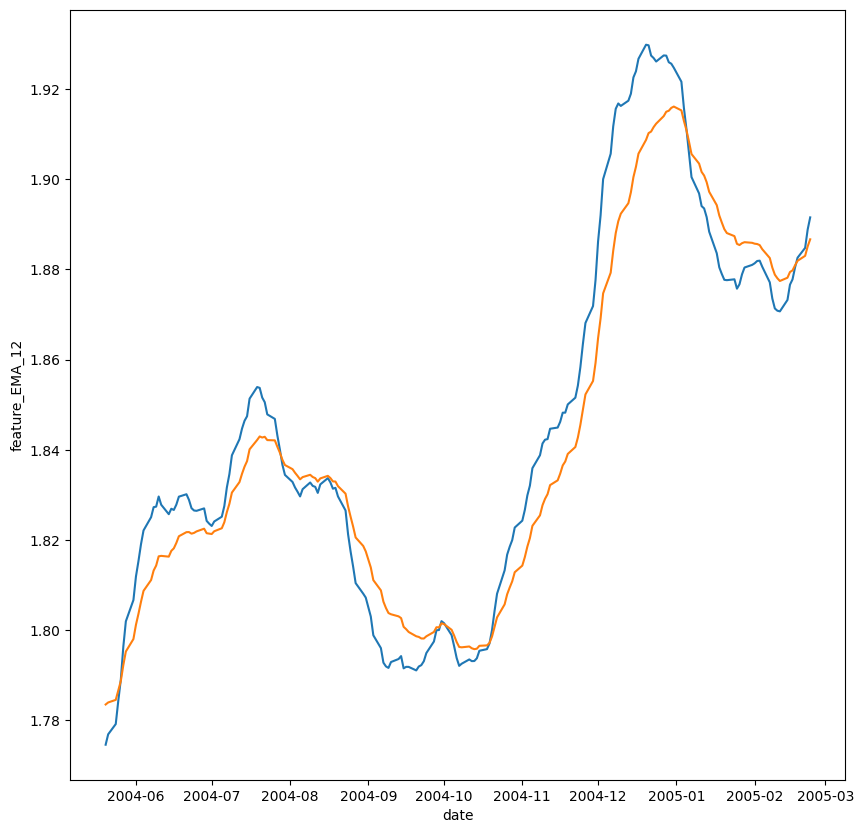

In [ ]:
plt.figure(3, figsize=(10, 10))
sns.lineplot(x=df.index[100:300], y=df['EMA_12'][100:300])
sns.lineplot(x=df.index[100:300], y=df['EMA_26'][100:300])

<Axes: xlabel='date', ylabel='MACD'>

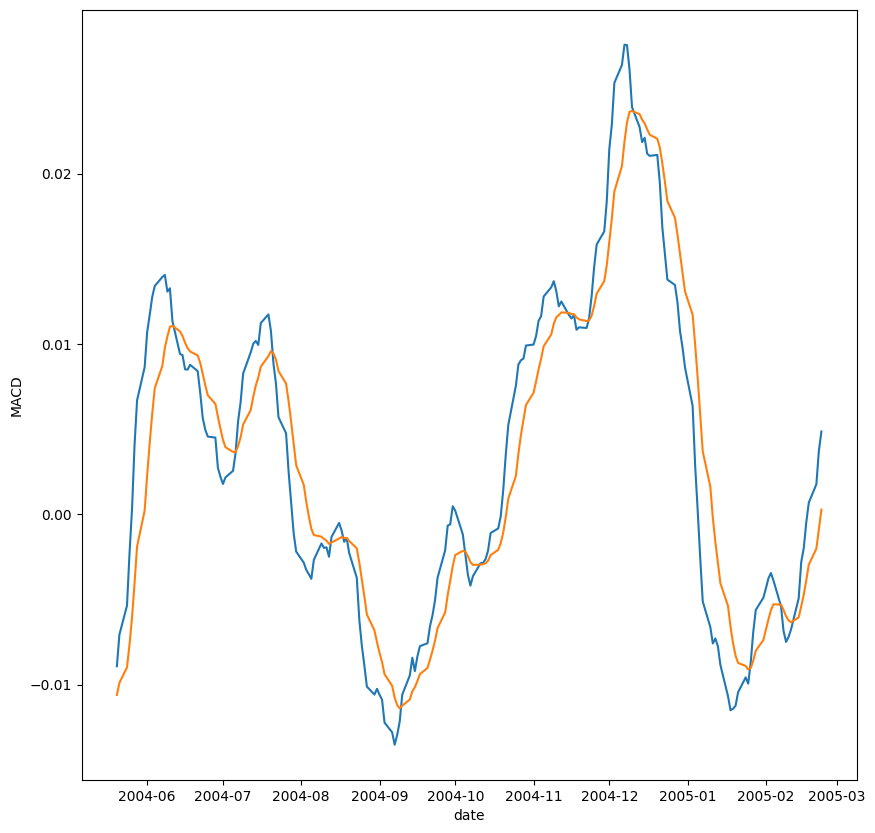

In [ ]:
#Moving average convergence and divergence
df['EMA_12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['close'].ewm(span=26, adjust=False).mean()

plt.figure(4, figsize=(10, 10))
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['MACD_9'] = df['MACD'].ewm(span=9, adjust=False).mean()

df.drop(['EMA_12', 'EMA_26'], inplace=True, axis=1)

sns.lineplot(x=df.index[100:300], y=df['MACD'][100:300])
sns.lineplot(x=df.index[100:300], y=df['MACD_9'][100:300])

In [ ]:
df.head(5)

,open,high,low,close,day,week,month,year,feature_Tenkan_sen,feature_Kijun_sen,feature_Senkou_A,feature_Senkou_B,feature_Chikou_span,feature_EMA_9,feature_EMA_12,feature_EMA_26,feature_MACD,feature_MMACD_9
date,,,,,,,,,,,,,,,,,,
2004-01-01,1.788813,1.788813,1.781705,1.785204,4,1,1,2004,1.818503,1.810954,1.816779,1.8391,1.847507,1.785204,1.785204,1.785204,0.000000,0.000000
2004-01-02,1.785587,1.795010,1.779201,1.793690,5,1,1,2004,1.818503,1.810954,1.816779,1.8391,1.859704,1.786901,1.786510,1.785833,0.000677,0.000135
2004-01-05,1.795493,1.810315,1.795107,1.807207,1,2,1,2004,1.818503,1.810954,1.816779,1.8391,1.867309,1.790962,1.789694,1.787416,0.002278,0.000564
2004-01-06,1.807403,1.827786,1.805510,1.821295,2,2,1,2004,1.818503,1.810954,1.816779,1.8391,1.892506,1.797029,1.794555,1.789925,0.004630,0.001377
2004-01-07,1.820897,1.825584,1.812711,1.817785,3,2,1,2004,1.818503,1.810954,1.816779,1.8391,1.893007,1.801180,1.798129,1.791989,0.006140,0.002330


In [ ]:
#Bollinger Bands
df['BB_upper'] = df['close'].rolling(window=10).mean() + 2 * df['close'].rolling(window=10).std()
df['BB_lower'] = df['close'].rolling(window=10).mean() - 2 * df['close'].rolling(window=10).std()


<Axes: xlabel='date', ylabel='BB_upper'>

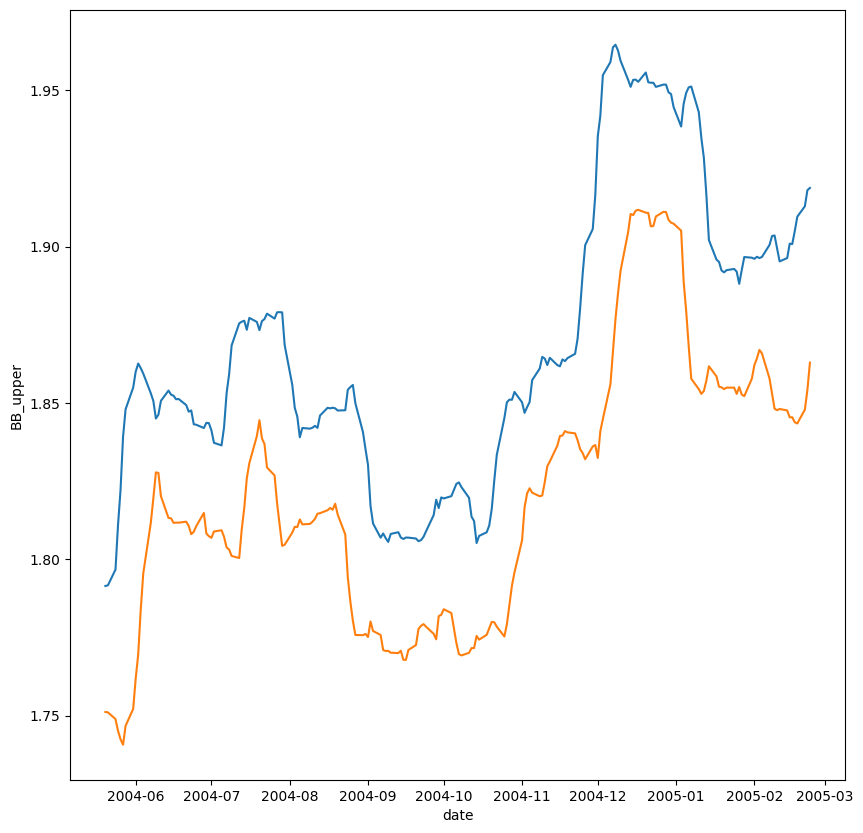

In [ ]:
plt.figure(5, figsize=(10, 10))
sns.lineplot(x=df.index[100:300], y=df['BB_upper'][100:300])
sns.lineplot(x=df.index[100:300], y=df['BB_lower'][100:300])


<Axes: xlabel='date', ylabel='BB_upper'>

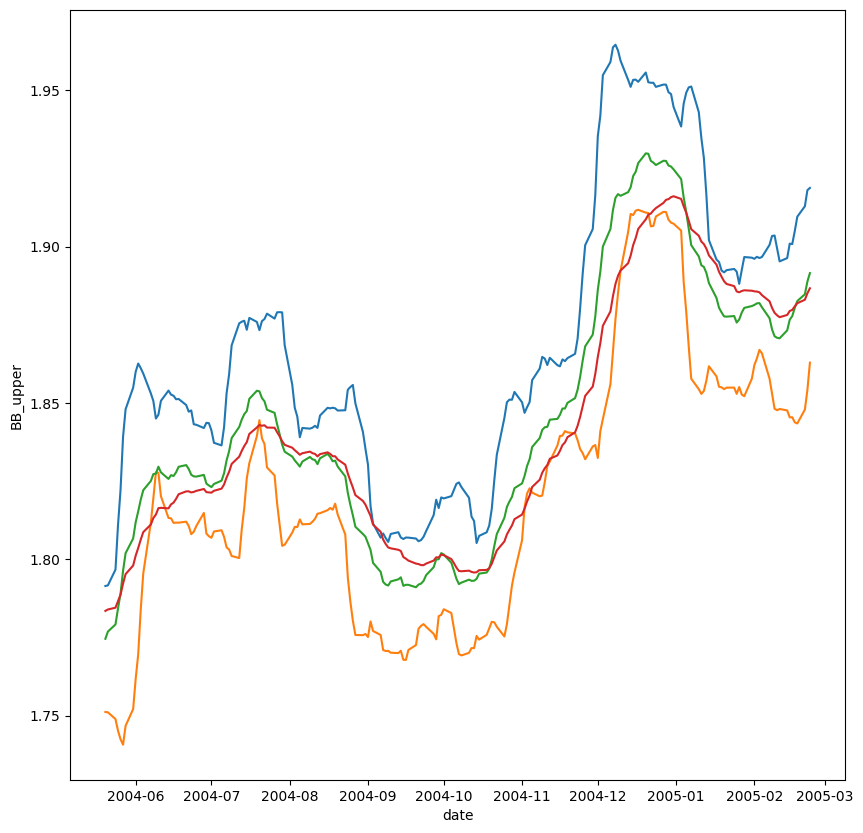

In [ ]:
plt.figure(6, figsize=(10, 10))
sns.lineplot(x=df.index[100:300], y=df['BB_upper'][100:300])
sns.lineplot(x=df.index[100:300], y=df['BB_lower'][100:300])

sns.lineplot(x=df.index[100:300], y=df['EMA_12'][100:300])
sns.lineplot(x=df.index[100:300], y=df['EMA_26'][100:300])

In [ ]:
#Relative Strength Index
delta = df['close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Calculate the average gain and loss
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Calculate the Relative Strength (RS)
rs = avg_gain / avg_loss

# Calculate the Relative Strength Index (RSI)
df['RSI'] = 100 - (100 / (1 + rs))


<Axes: xlabel='date', ylabel='RSI'>

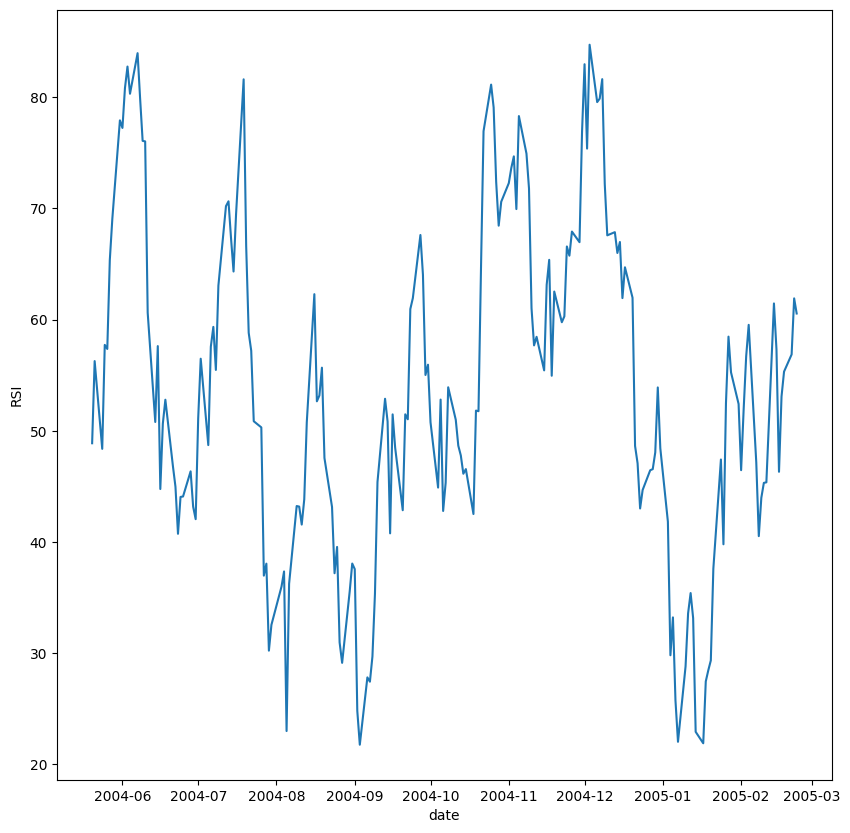

In [ ]:
plt.figure(7, figsize=(10, 10))
sns.lineplot(x=df.index[100:300], y=df['RSI'][100:300])

In [ ]:

#Stochastic oscillator
df['Stochastic_K'] = (df['close'] - df['low'].rolling(window=14).min()) / (df['high'].rolling(window=14).max() - df['low'].rolling(window=14).min())
df['Stochastic_D'] = df['Stochastic_K'].rolling(window=3).mean()


<Axes: xlabel='date', ylabel='Stochastic_D'>

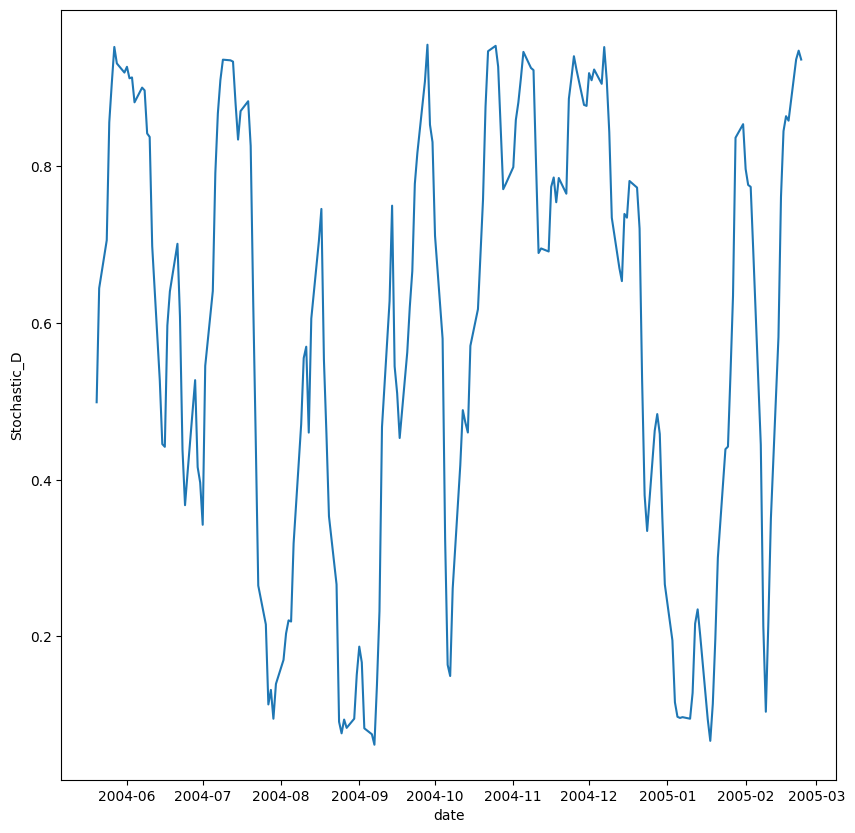

In [ ]:
plt.figure(9, figsize=(10, 10))
sns.lineplot(x=df.index[100:300], y=df['Stochastic_D'][100:300])

In [ ]:
#average try range
df['TR'] = np.maximum(df['high'] - df['low'], np.abs(df['high'] - df['close'].shift()))
df['ATR'] = df['TR'].rolling(window=14).mean()

<Axes: xlabel='date', ylabel='ATR'>

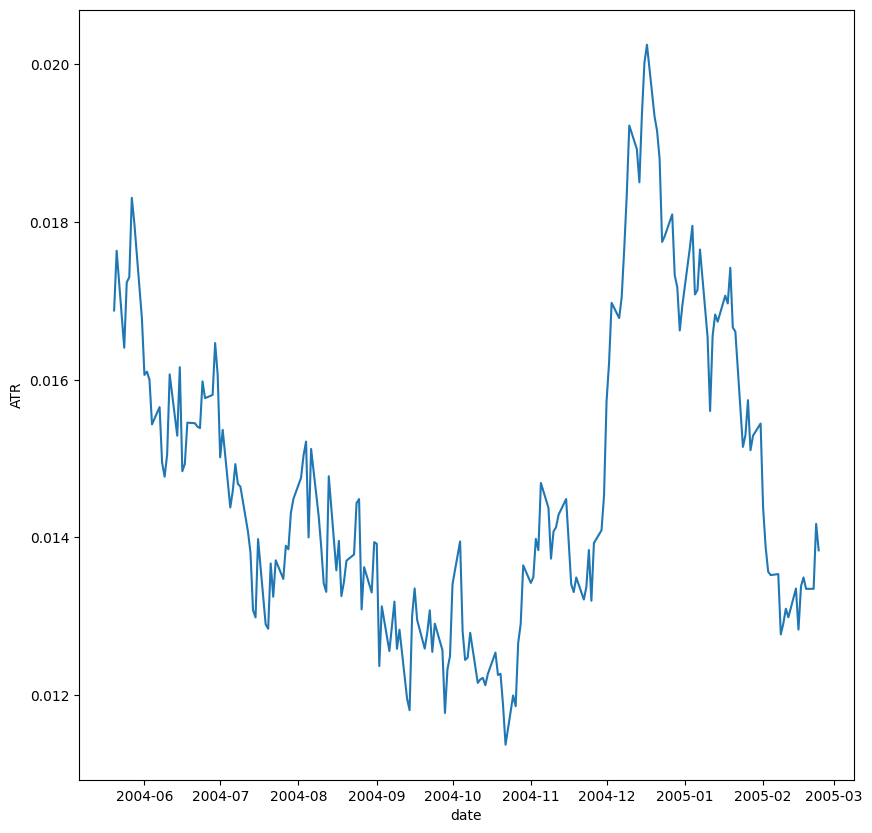

In [ ]:
plt.figure(8, figsize=(10, 10))
sns.lineplot(x=df.index[100:300], y=df['ATR'][100:300])

##### Support and Resistance Feature Engineering

In [ ]:
df = GU_daily.copy()
#Ichimoku cloud
def calculate_ichimoku_cloud(df):
    df['EMA_9'] = df['close'].ewm(span=9, adjust=False).mean()
    # Calculate Tenkan-sen
    high_9 = df['high'].rolling(window=9).max()
    low_9 = df['low'].rolling(window=9).min()
    df['Tenkan_sen'] = (high_9 + low_9) / 2

    # Calculate Kijun-sen
    high_26 = df['high'].rolling(window=26).max()
    low_26 = df['low'].rolling(window=26).min()
    df['Kijun_sen'] = (high_26 + low_26) / 2

    # Calculate Senkou Span A
    df['Senkou_A'] = ((df['Tenkan_sen'] + df['Kijun_sen']) / 2).shift(26)

    # Calculate Senkou Span B
    high_52 = df['high'].rolling(window=52).max()
    low_52 = df['low'].rolling(window=52).min()
    df['Senkou_B'] = ((high_52 + low_52) / 2).shift(26)

    # Calculate Chikou Span
    df['Chikou_span'] = df['close'].shift(-26)

    return df

In [ ]:
df = calculate_ichimoku_cloud(GU_daily)
print(df[['Tenkan_sen', 'Kijun_sen', 'Senkou_A', 'Senkou_B', 'Chikou_span']])


            feature_Tenkan_sen  feature_Kijun_sen  feature_Senkou_A  \
date                                                                  
2004-01-01                 NaN                NaN               NaN   
2004-01-02                 NaN                NaN               NaN   
2004-01-05                 NaN                NaN               NaN   
2004-01-06                 NaN                NaN               NaN   
2004-01-07                 NaN                NaN               NaN   
...                        ...                ...               ...   
2023-12-25            1.264863           1.261890          1.231448   
2023-12-26            1.270258           1.262013          1.231995   
2023-12-27            1.270797           1.262521          1.234407   
2023-12-28            1.272077           1.265830          1.234407   
2023-12-29            1.272077           1.266573          1.235518   

            feature_Senkou_B  feature_Chikou_span  
date                    

<Axes: xlabel='date', ylabel='feature_Senkou_A'>

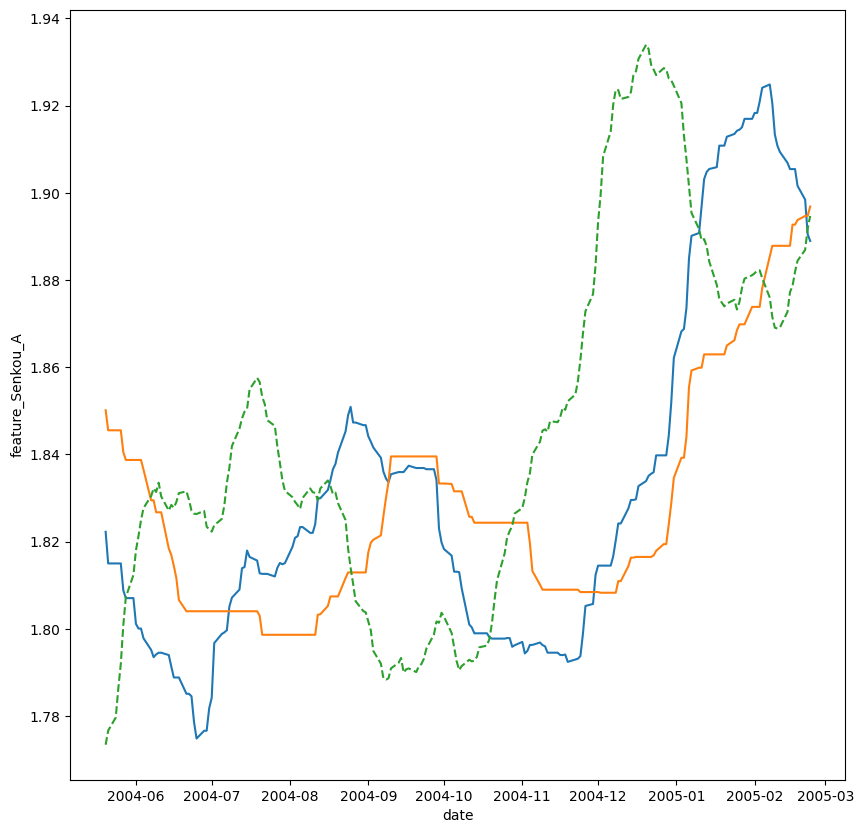

In [ ]:
plt.figure(10, figsize=(10, 10))
sns.lineplot(x=df.index[100:300], y=df['Senkou_A'][100:300])
sns.lineplot(x=df.index[100:300], y=df['Senkou_B'][100:300])
sns.lineplot(x=df.index[100:300], y=df['EMA_9'][100:300], ls='--')

In [ ]:
#%pip install trendln

In [ ]:
#TrendLn library for s&r
import trendln

df = merged_gu.copy()

Pmin = []
Pmax = []
intv = 15

for i in range(int(np.round(len(df)/intv,0))):
# Calculate support and resistance levels
  mins, maxs = trendln.calc_support_resistance(df[i*intv:intv*(i+1)].close, accuracy=2)
  #minimaIdxs, pmin, mintrend, minwindows = trendln.calc_support_resistance((df.low[i*intv:intv*(i+1)], None), accuracy=2)
  maximumIdxs, pmax, maxtrend, maxwindows = trendln.calc_support_resistance((df.high_weekly[i*intv:intv*(i+1)], None), accuracy=2)

  for l in pmax:
    Pmax.append(l)
  #for l in pmin:
    #Pmin.append(l)

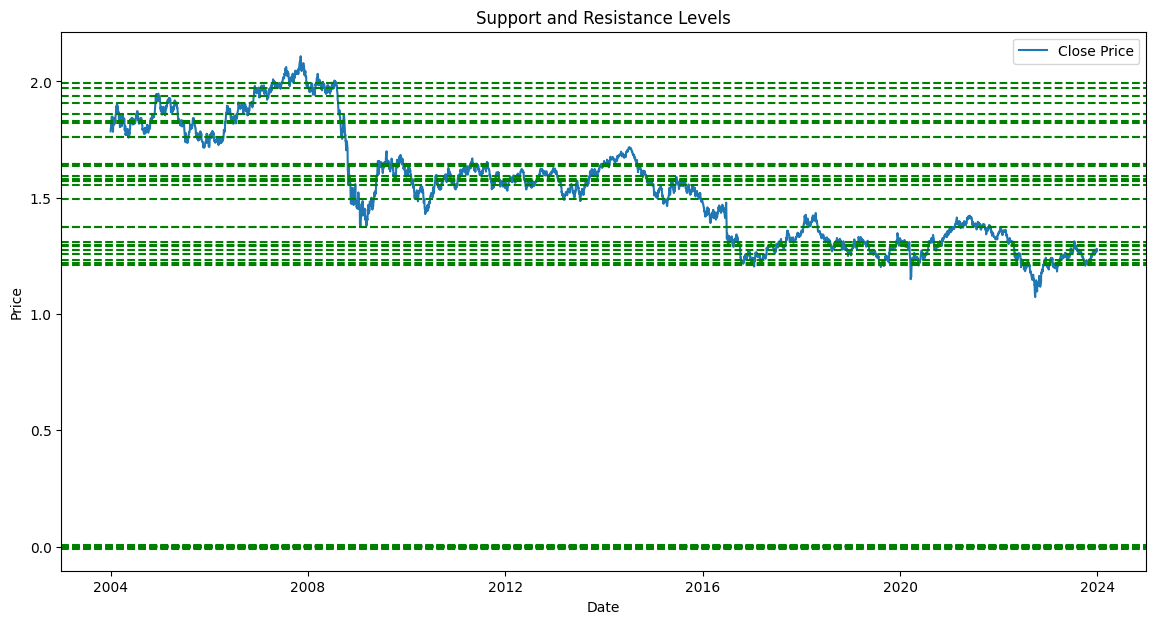

In [ ]:
# Assuming df is your DataFrame and 'close' is the column with closing prices
plt.figure(11, figsize=(14, 7))
plt.plot(df['close'], label='Close Price')

# Plot support levels
for level in Pmin:
    plt.axhline(y=level, color='green', linestyle='--')

# Plot resistance levels
for level in Pmax:
    plt.axhline(y=level, color='green', linestyle='--')

plt.title('Support and Resistance Levels')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


##### LSTM feature extraction

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Model

In [ ]:
df = GU_daily.copy()

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df[['close', 'high', 'low', 'open']])[:4800]


In [ ]:
sequence_length = 30  # Define the window size

sequences = []
for i in range(sequence_length, len(data)):
  sequences.append(data[i-sequence_length:i, :])

In [ ]:
new_data = data[-sequence_length:]
new_data = new_data.reshape(1, sequence_length, data.shape[1])

In [ ]:
model = Sequential()
model.add(LSTM(units=45, return_sequences=True, input_shape=(sequence_length, data.shape[1])))
model.add(LSTM(units=20, return_sequences=True))  # Both layers return sequences
model.add(LSTM(units=8))  # Final layer, return_sequences is False
model.add(Dense(units=data.shape[1]))  # Number of features to extract

model.compile(loss='mse', optimizer='adam')

model.fit(sequences, data[sequence_length:], epochs=100, batch_size=32)

# Access hidden states at all time steps for both layers
lstm1_output = model.layers[0].output  # Assuming first layer is LSTM
lstm2_output = model.layers[1].output

features = model.predict(new_data)

hidden_model = Model(inputs=model.input, outputs=[lstm1_output, lstm2_output])

# Use hidden_model for prediction on new data
features1, features2 = hidden_model.predict(new_data)

# Concatenate features from both layers (optional)
#all_features = np.concatenate((features1, features2), axis=2)

ValueError: Data cardinality is ambiguous:
  x sizes: 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30
  y sizes: 4770
Make sure all arrays contain the same number of samples.

In [ ]:
len(features2[0][0])

20

In [ ]:
list(lstm1_output[1])

[<KerasTensor: shape=(45,) dtype=float32 (created by layer 'tf.__operators__.getitem_66')>,
 <KerasTensor: shape=(45,) dtype=float32 (created by layer 'tf.__operators__.getitem_67')>,
 <KerasTensor: shape=(45,) dtype=float32 (created by layer 'tf.__operators__.getitem_68')>,
 <KerasTensor: shape=(45,) dtype=float32 (created by layer 'tf.__operators__.getitem_69')>,
 <KerasTensor: shape=(45,) dtype=float32 (created by layer 'tf.__operators__.getitem_70')>,
 <KerasTensor: shape=(45,) dtype=float32 (created by layer 'tf.__operators__.getitem_71')>,
 <KerasTensor: shape=(45,) dtype=float32 (created by layer 'tf.__operators__.getitem_72')>,
 <KerasTensor: shape=(45,) dtype=float32 (created by layer 'tf.__operators__.getitem_73')>,
 <KerasTensor: shape=(45,) dtype=float32 (created by layer 'tf.__operators__.getitem_74')>,
 <KerasTensor: shape=(45,) dtype=float32 (created by layer 'tf.__operators__.getitem_75')>,
 <KerasTensor: shape=(45,) dtype=float32 (created by layer 'tf.__operators__.get

In [ ]:
lstm2_cols = [f"LSTM_feature" for i in range(20)]

# Assuming features.shape is (1, sequence_length, total_features)
lstm1_df = pd.DataFrame(features[0, :, :25], columns=lstm2_cols)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

##### Trading Simulation

##### Run v2

In [ ]:
GU_daily.head(5)

,open,high,low,close,day,week,month,year
date,,,,,,,,
2004-01-01,1.788813,1.788813,1.781705,1.785204,4,1,1,2004
2004-01-02,1.785587,1.795010,1.779201,1.793690,5,1,1,2004
2004-01-05,1.795493,1.810315,1.795107,1.807207,1,2,1,2004
2004-01-06,1.807403,1.827786,1.805510,1.821295,2,2,1,2004
2004-01-07,1.820897,1.825584,1.812711,1.817785,3,2,1,2004


In [ ]:
len(GU_daily.copy()[:'2021-06-30']), len(GU_daily.copy()['2021-06-30':])

(4565, 653)

In [ ]:
#df = GU_daily.copy()

split_date = '2021-06-30'

df['daily_open'] = df['open']
df['daily_high'] = df['high']
df['daily_low'] = df['low']
df['daily_close'] = df['close']

train_df = df.copy()[:split_date]
test_df = df.copy()[split_date:]

cols = []

for i, j in enumerate(train_df):
    if i>3:
        cols.append(j+'_'+'feature')
    else:
        cols.append(j)

train_df.columns = cols
test_df.columns = cols

In [ ]:
train_df.head(5)

,open,high,low,close,day_feature,week_feature,month_feature,year_feature,MACD_feature,MACD_9_feature,daily_open_feature,daily_high_feature,daily_low_feature,daily_close_feature
date,,,,,,,,,,,,,,
2004-01-01,1.788813,1.788813,1.781705,1.785204,4,1,1,2004,0.000000,0.000000,1.788813,1.788813,1.781705,1.785204
2004-01-02,1.785587,1.795010,1.779201,1.793690,5,1,1,2004,0.000677,0.000135,1.785587,1.795010,1.779201,1.793690
2004-01-05,1.795493,1.810315,1.795107,1.807207,1,2,1,2004,0.002278,0.000564,1.795493,1.810315,1.795107,1.807207
2004-01-06,1.807403,1.827786,1.805510,1.821295,2,2,1,2004,0.004630,0.001377,1.807403,1.827786,1.805510,1.821295
2004-01-07,1.820897,1.825584,1.812711,1.817785,3,2,1,2004,0.006140,0.002330,1.820897,1.825584,1.812711,1.817785


Descrete action space environment

In [ ]:
from environments import TradingEnv

In [ ]:
env = TradingEnv(df = train_df, positions = [-0.05, 0, 0.05], portfolio_initial_value = 100000, initial_position= 0.05, max_episode_duration=len(train_df)*3/4)

observation, info = env.reset()

print(observation)
info

[ 5.0000000e+00  1.8000000e+01  5.0000000e+00  2.0080000e+03
 -1.9827981e-03 -1.9240683e-03  1.9787090e+00  1.9897330e+00
  1.9711040e+00  1.9714921e+00  5.0000001e-02  5.0000001e-02]


{'idx': 1131,
 'step': 0,
 'date': numpy.datetime64('2008-05-02T00:00:00.000000000'),
 'position_index': 2,
 'position': 0.05,
 'real_position': 0.05,
 'data_open': 1.978709,
 'data_low': 1.971104,
 'data_close': 1.971492,
 'data_high': 1.989733,
 'portfolio_valuation': 100000.0,
 'portfolio_distribution_asset': 2536.1502861791982,
 'portfolio_distribution_fiat': 95000.0,
 'portfolio_distribution_borrowed_asset': 0,
 'portfolio_distribution_borrowed_fiat': 0,
 'portfolio_distribution_interest_asset': 0,
 'portfolio_distribution_interest_fiat': 0,
 'reward': 0}

In [ ]:
env.observation_space.shape

(12,)

In [ ]:
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0))
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']))

In [ ]:
total_timesteps = int(2e5)

#### PPO run

In [ ]:
ppo = PPO("MlpPolicy", DummyVecEnv([lambda: env]), verbose = 1, n_epochs=20)
ppo.learn(total_timesteps=total_timesteps)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1113 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
Market Return : -28.86%   |   Portfolio Return :  0.78%   |   Position Changes : 2516   |   Episode Length : 3752   |   
-----------------------------------------
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010283936 |
|    clip_fraction        | 0.0651      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.00414    |
|    learning_rate        | 0.0003      |
|    loss                 | 3.24        |
|    n_updates            | 20          |
|    policy_gradient_l

In [ ]:
env = TradingEnv(df = test_df, positions = [-0.05, 0, 0.05], portfolio_initial_value = 100000, initial_position= 0.05, max_episode_duration=len(test_df)-1)

# Run an episode until it ends :
tot_episode_reward = 0
ppo_episode_reward_tracker = []
current_bal = 100000
tot_episode_profit = 0
ppo_episode_profit_tracker = []
ppo_balance_tracker = []
ppo_position_tracker = []

done, truncated = False, False
observation, info = env.reset()
while not done and not truncated:
     # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index,_ = ppo.predict(observation)
    observation, reward, done, truncated, info = env.step(position_index)

    env.render()
    time.sleep(0.1)
    clear_output(wait=True)
    print(observation, reward)
    print(info)

      #More metrics
    ppo_balance_tracker.append(current_bal)
    tot_episode_reward += reward
    ppo_episode_reward_tracker.append(reward)

    profit = info['portfolio_valuation'] - current_bal
    tot_episode_profit += profit
    ppo_episode_profit_tracker.append(profit)
    current_bal = info['portfolio_valuation']

    ppo_position_tracker.append(info['position'])


[ 4.0000000e+00  5.2000000e+01  1.2000000e+01  2.0230000e+03
  6.8129497e-03  6.6692969e-03  1.2802290e+00  1.2826760e+00
  1.2740149e+00  1.2800820e+00 -5.0000001e-02 -5.0303854e-02] -1.0
{'idx': 651, 'step': 651, 'date': numpy.datetime64('2023-12-28T00:00:00.000000000'), 'position_index': array(0), 'position': -0.05, 'real_position': -0.05030385511908752, 'data_open': 1.280229, 'data_low': 1.274015, 'data_close': 1.280082, 'data_high': 1.282676, 'portfolio_valuation': 100264.48918577444, 'portfolio_distribution_asset': 0, 'portfolio_distribution_fiat': 105308.17952336495, 'portfolio_distribution_borrowed_asset': 3940.13066162208, 'portfolio_distribution_borrowed_fiat': 0, 'portfolio_distribution_interest_asset': 0.0, 'portfolio_distribution_interest_fiat': 0, 'reward': -1.0}


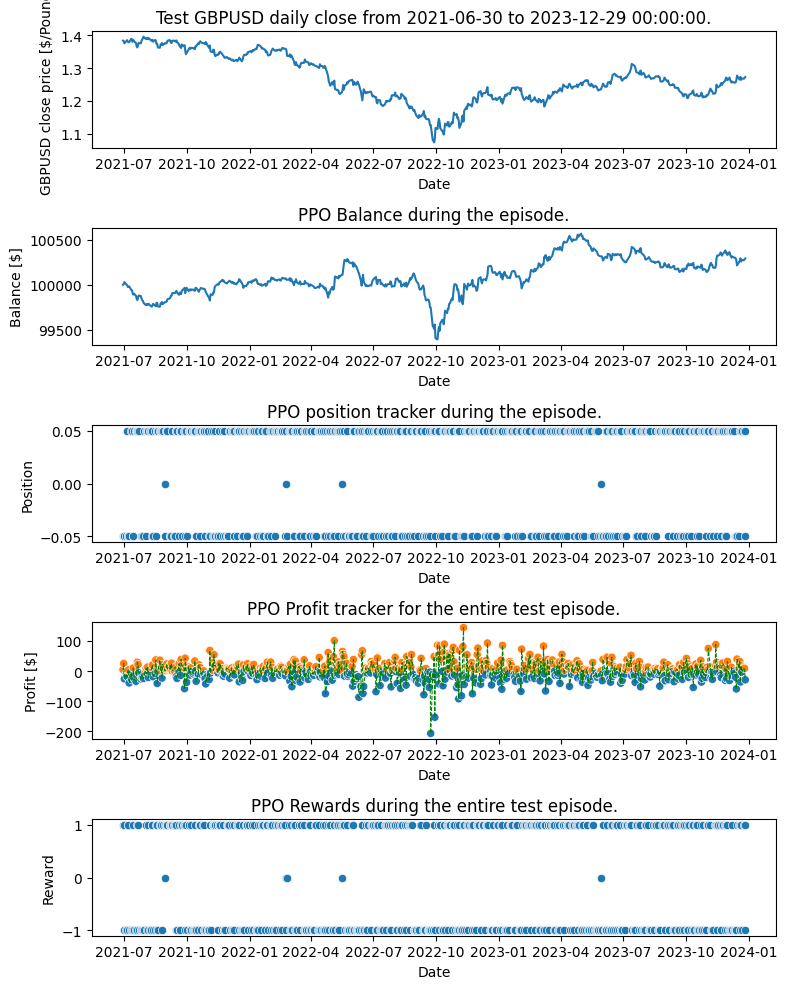

In [ ]:
fig, axs = plt.subplots(nrows=5, figsize=(8,10))

sns.lineplot(x=test_df.index[:-2], y=test_df['close'][:-2], ax=axs[0])
axs[0].set_title(f'Test GBPUSD daily close from {split_date} to {test_df.index[-1]}.')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('GBPUSD close price [$/Pound]')

sns.lineplot(x=test_df.index[:-2], y=ppo_balance_tracker, ax=axs[1])
axs[1].set_title('PPO Balance during the episode.')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Balance [$]')

sns.scatterplot(x=test_df.index[:-2], y=ppo_position_tracker, ax=axs[2])
axs[2].set_title('PPO position tracker during the episode.')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Position')

sns.lineplot(x=test_df.index[:-2], y=ppo_episode_profit_tracker, ax=axs[3], ls='--', color='g', size=0.5, legend=False)
sns.scatterplot(x=test_df.index[:-2], y=ppo_episode_profit_tracker, ax=axs[3], hue=[x>=0 for x in ppo_episode_profit_tracker], legend=False)
axs[3].set_title('PPO Profit tracker for the entire test episode.')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Profit [$]')

sns.scatterplot(x=test_df.index[:-2], y=ppo_episode_reward_tracker, ax=axs[4], hue=[], legend=False)
axs[4].set_title('PPO Rewards during the entire test episode.')
axs[4].set_xlabel('Date')
axs[4].set_ylabel('Reward')

plt.tight_layout()
plt.show()

In [ ]:
ppo_position_tracker.count(-0.05)

216

##### Run 3

#### DQN

In [ ]:
Dqn = DQN('MlpPolicy', env, verbose = 1, buffer_size=1000)
Dqn.learn(total_timesteps=total_timesteps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Market Return : -7.53%   |   Portfolio Return : -1.15%   |   
Market Return : -7.53%   |   Portfolio Return :  0.83%   |   
Market Return : -7.53%   |   Portfolio Return : -0.31%   |   
Market Return : -7.53%   |   Portfolio Return :  0.31%   |   
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 651      |
|    ep_rew_mean      | -12.8    |
|    exploration_rate | 0.876    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 964      |
|    time_elapsed     | 2        |
|    total_timesteps  | 2604     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.416    |
|    n_updates        | 625      |
----------------------------------
Market Return : -7.53%   |   Portfolio Return : -0.28%   |   
Market Return : -7.53%   |   Portfolio Return : -0.94%   |   
Market Re

In [ ]:
env = TradingEnv(df = test_df, positions = [-0.05, 0, 0.05], portfolio_initial_value = 100000, initial_position= 0.05, max_episode_duration=len(test_df)-1)

# Run an episode until it ends :
tot_episode_reward = 0
dqn_episode_reward_tracker = []
current_bal = 100000
tot_episode_profit = 0
dqn_episode_profit_tracker = []
dqn_balance_tracker = []
dqn_position_tracker = []

done, truncated = False, False
observation, info = env.reset()
while not done and not truncated:
     # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    action,_ = Dqn.predict(observation, deterministic=False)
    observation, reward, done, truncated, info = env.step(action)

    env.render()
    time.sleep(0.1)
    clear_output(wait=True)
    print(observation, reward)
    print(info)

    #More metrics
    dqn_balance_tracker.append(current_bal)
    tot_episode_reward += reward
    dqn_episode_reward_tracker.append(reward)

    profit = info['portfolio_valuation'] - current_bal
    tot_episode_profit += profit
    dqn_episode_profit_tracker.append(profit)
    current_bal = info['portfolio_valuation']

    dqn_position_tracker.append(info['position'])


[4.0000000e+00 5.2000000e+01 1.2000000e+01 2.0230000e+03 6.8129497e-03
 6.6692969e-03 1.2802290e+00 1.2826760e+00 1.2740149e+00 1.2800820e+00
 5.0000001e-02 5.0463721e-02] 1.0
{'idx': 651, 'step': 651, 'date': numpy.datetime64('2023-12-28T00:00:00.000000000'), 'position_index': array(2), 'position': 0.05, 'real_position': 0.05046372005278483, 'data_open': 1.280229, 'data_low': 1.274015, 'data_close': 1.280082, 'data_high': 1.282676, 'portfolio_valuation': 100557.56782220377, 'portfolio_distribution_asset': 3964.206161612002, 'portfolio_distribution_fiat': 95483.05887043515, 'portfolio_distribution_borrowed_asset': 0, 'portfolio_distribution_borrowed_fiat': 0, 'portfolio_distribution_interest_asset': 0, 'portfolio_distribution_interest_fiat': 0, 'reward': 1.0}


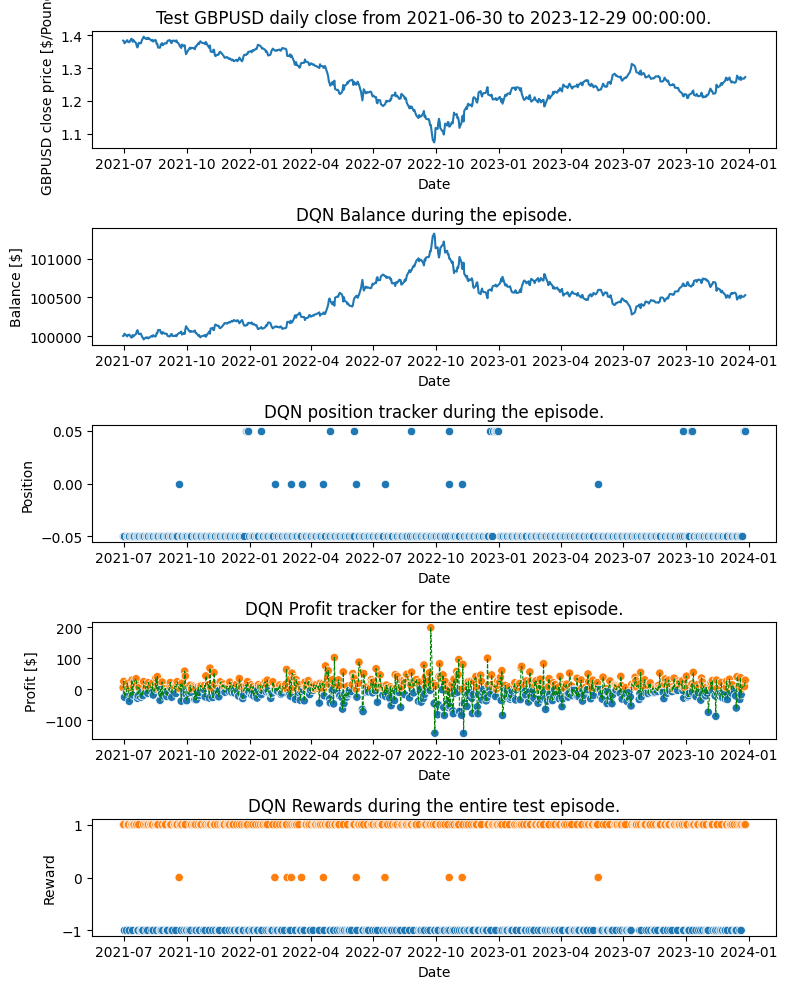

In [ ]:
fig, axs = plt.subplots(nrows=5, figsize=(8,10))

sns.lineplot(x=test_df.index[:-2], y=test_df['close'][:-2], ax=axs[0])
axs[0].set_title(f'Test GBPUSD daily close from {split_date} to {test_df.index[-1]}.')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('GBPUSD close price [$/Pound]')

sns.lineplot(x=test_df.index[:-2], y=dqn_balance_tracker, ax=axs[1])
axs[1].set_title('DQN Balance during the episode.')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Balance [$]')

sns.scatterplot(x=test_df.index[:-2], y=dqn_position_tracker, ax=axs[2])
axs[2].set_title('DQN position tracker during the episode.')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Position')

sns.lineplot(x=test_df.index[:-2], y=dqn_episode_profit_tracker, ax=axs[3], ls='--', color='g', size=0.5, legend=False)
sns.scatterplot(x=test_df.index[:-2], y=dqn_episode_profit_tracker, ax=axs[3], hue=[x>=0 for x in dqn_episode_profit_tracker], legend=False)
axs[3].set_title('DQN Profit tracker for the entire test episode.')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Profit [$]')


sns.scatterplot(x=test_df.index[:-2], y=dqn_episode_reward_tracker, ax=axs[4], hue=[x>=0 for x in dqn_episode_reward_tracker], legend=False)
axs[4].set_title('DQN Rewards during the entire test episode.')
axs[4].set_xlabel('Date')
axs[4].set_ylabel('Reward')


plt.tight_layout()
plt.show()

In [ ]:
env = TradingEnv(df = test_df, positions = [-0.05, 0, 0.05], portfolio_initial_value = 100000, initial_position= 0.05, max_episode_duration=len(test_df)-1)

def simulator(env=env, model=model):

  # Run an episode until it ends :
  tot_episode_reward = 0
  episode_reward_tracker = []
  current_bal = 100000
  tot_episode_profit = 0
  episode_profit_tracker = []
  balance_tracker = []
  position_tracker = []

  done, truncated = False, False
  observation, info = env.reset()
  while not done and not truncated:
     # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
      action,_ = model.predict(observation, deterministic=False)
      observation, reward, done, truncated, info = env.step(action)

      env.render()
      time.sleep(0.1)
      clear_output(wait=True)

    #More metrics
      balance_tracker.append(current_bal)
      tot_episode_reward += reward
      episode_reward_tracker.append(reward)

      profit = info['portfolio_valuation'] - current_bal
      tot_episode_profit += profit
      episode_profit_tracker.append(profit)
      current_bal = info['portfolio_valuation']

      position_tracker.append(info['position'])

  fig, axs = plt.subplots(nrows=5, figsize=(8,10))

  sns.lineplot(x=test_df.index[:-2], y=test_df['close'][:-2], ax=axs[0])
  axs[0].set_title(f'Test GBPUSD daily close from {split_date} to {test_df.index[-1]}.')
  axs[0].set_xlabel('Date')
  axs[0].set_ylabel('GBPUSD close price [$/Pound]')

  sns.lineplot(x=test_df.index[:-2], y=balance_tracker, ax=axs[1])
  axs[1].set_title('Balance during the episode.')
  axs[1].set_xlabel('Date')
  axs[1].set_ylabel('Balance [$]')

  sns.scatterplot(x=test_df.index[:-2], y=position_tracker, ax=axs[2])
  axs[2].set_title('Position tracker during the episode.')
  axs[2].set_xlabel('Date')
  axs[2].set_ylabel('Position')

  sns.lineplot(x=test_df.index[:-2], y=episode_profit_tracker, ax=axs[3], ls='--', color='g', size=0.5, legend=False)
  sns.scatterplot(x=test_df.index[:-2], y=episode_profit_tracker, ax=axs[3], hue=[x>=0 for x in episode_profit_tracker], legend=False)
  axs[3].set_title('Profit tracker for the entire test episode.')
  axs[3].set_xlabel('Date')
  axs[3].set_ylabel('Profit [$]')

  sns.scatterplot(x=test_df.index[:-2], y=episode_reward_tracker, ax=axs[4], hue=[x>=0 for x in episode_reward_tracker], legend=False)
  axs[4].set_title('Rewards during the entire test episode.')
  axs[4].set_xlabel('Date')
  axs[4].set_ylabel('Reward')

  plt.tight_layout()
  plt.show()

NameError: name 'model' is not defined

Continuous action space environment

In [ ]:
from environments import TradingEnvContinuous

In [ ]:
env = TradingEnvContinuous(df = train_df, positions = [-0.05, 0, 0.05], portfolio_initial_value = 100000, initial_position= 0.05, max_episode_duration=len(train_df)*3/4)

observation, info = env.reset()

print(observation)
info

[5.0000000e+00 2.8000000e+01 7.0000000e+00 2.0050000e+03 1.7618545e+00
 1.7662537e+00 1.7854958e+00 1.7579020e+00 1.7637000e+00 1.7509151e+00
 1.7509151e+00 5.0000001e-02 5.0000001e-02]


{'idx': 401,
 'step': 0,
 'date': numpy.datetime64('2005-07-15T00:00:00.000000000'),
 'position_index': 2,
 'position': 0.05,
 'real_position': 0.05,
 'data_open': 1.757902,
 'data_low': 1.750915,
 'data_close': 1.750915,
 'data_high': 1.7637,
 'portfolio_valuation': 100000.0,
 'portfolio_distribution_asset': 2855.6497602682025,
 'portfolio_distribution_fiat': 95000.0,
 'portfolio_distribution_borrowed_asset': 0,
 'portfolio_distribution_borrowed_fiat': 0,
 'portfolio_distribution_interest_asset': 0,
 'portfolio_distribution_interest_fiat': 0,
 'reward': 0}

In [ ]:
env.observation_space.shape

(13,)

In [ ]:
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )
# Then, run your episode(s)

In [ ]:
total_timesteps = int(1e5)

DDPG

In [ ]:
n_actions = env.action_space.shape
action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=0.5*np.ones(n_actions))

In [ ]:
ddpg = DDPG('MlpPolicy', env, action_noise=action_noise, verbose = 1)
ddpg.learn(total_timesteps=total_timesteps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Market Return : -24.47%   |   Portfolio Return :  0.17%   |   Position Changes : 269   |   Episode Length : 4348   |   
Market Return : -22.41%   |   Portfolio Return : -1.62%   |   Position Changes : 118   |   Episode Length : 4026   |   
Market Return : -24.79%   |   Portfolio Return : -1.30%   |   Position Changes : 133   |   Episode Length : 4432   |   
Market Return : -25.89%   |   Portfolio Return : -1.29%   |   Position Changes : 0   |   Episode Length : 4523   |   
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.33e+03 |
|    ep_rew_mean     | -40      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 35       |
|    time_elapsed    | 485      |
|    total_timesteps | 17325    |
| train/             |          |
|    actor_loss      | -14.1    |
|    critic_loss     | 0.875    |
|    learning_rate  

In [ ]:
env = TradingEnvContinuous(df = test_df, positions = [-0.05, 0, 0.05], portfolio_initial_value = 100000, initial_position= 0.05, max_episode_duration=len(test_df)-1)

# Run an episode until it ends :
tot_episode_reward = 0
ddpg_episode_reward_tracker = []
current_bal = 100000
tot_episode_profit = 0
ddpg_episode_profit_tracker = []
ddpg_balance_tracker = []
ddpg_position_tracker = []

done, truncated = False, False
observation, info = env.reset()
while not done and not truncated:
     # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    action,_ = ddpg.predict(observation, deterministic=True)
    observation, reward, done, truncated, info = env.step(action)

    env.render()
    time.sleep(0.1)
    clear_output(wait=True)
    print(observation, reward)
    print(info)

    #More metrics
    ddpg_balance_tracker.append(current_bal)
    tot_episode_reward += reward
    ddpg_episode_reward_tracker.append(reward)

    profit = info['portfolio_valuation'] - current_bal
    tot_episode_profit += profit
    ddpg_episode_profit_tracker.append(profit)
    current_bal = info['portfolio_valuation']

    ddpg_position_tracker.append(info['position'])

[4.0000000e+00 5.2000000e+01 1.2000000e+01 2.0230000e+03 1.2706555e+00
 1.2691301e+00 1.2623172e+00 1.2802290e+00 1.2826760e+00 1.2740149e+00
 1.2800820e+00 5.0000001e-02 4.6411216e-02] 1.0
{'idx': 651, 'step': 651, 'date': numpy.datetime64('2023-12-28T00:00:00.000000000'), 'position_index': 2, 'position': 0.05, 'real_position': 0.046411216118220945, 'data_open': 1.280229, 'data_low': 1.274015, 'data_close': 1.280082, 'data_high': 1.282676, 'portfolio_valuation': 99623.6549818497, 'portfolio_distribution_asset': 3611.9990608802445, 'portfolio_distribution_fiat': 95000.0, 'portfolio_distribution_borrowed_asset': 0, 'portfolio_distribution_borrowed_fiat': 0, 'portfolio_distribution_interest_asset': 0, 'portfolio_distribution_interest_fiat': 0, 'reward': 1.0}


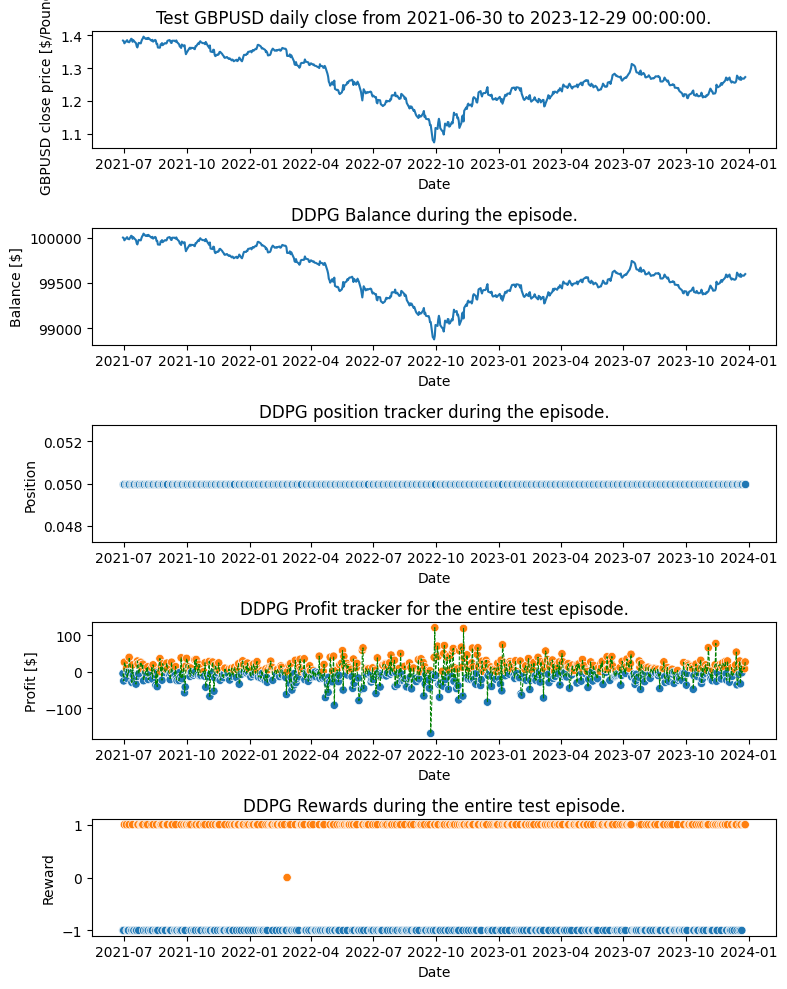

In [ ]:
fig, axs = plt.subplots(nrows=5, figsize=(8,10))

sns.lineplot(x=test_df.index[:-2], y=test_df['close'][:-2], ax=axs[0])
axs[0].set_title(f'Test GBPUSD daily close from {split_date} to {test_df.index[-1]}.')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('GBPUSD close price [$/Pound]')

sns.lineplot(x=test_df.index[:-2], y=ddpg_balance_tracker, ax=axs[1])
axs[1].set_title('DDPG Balance during the episode.')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Balance [$]')

sns.scatterplot(x=test_df.index[:-2], y=ddpg_position_tracker, ax=axs[2])
axs[2].set_title('DDPG position tracker during the episode.')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Position')

sns.lineplot(x=test_df.index[:-2], y=ddpg_episode_profit_tracker, ax=axs[3], ls='--', color='g', size=0.5, legend=False)
sns.scatterplot(x=test_df.index[:-2], y=ddpg_episode_profit_tracker, ax=axs[3], hue=[x>=0 for x in ddpg_episode_profit_tracker], legend=False)
axs[3].set_title('DDPG Profit tracker for the entire test episode.')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Profit [$]')


sns.scatterplot(x=test_df.index[:-2], y=ddpg_episode_reward_tracker, ax=axs[4], hue=[x>=0 for x in ddpg_episode_reward_tracker], legend=False)
axs[4].set_title('DDPG Rewards during the entire test episode.')
axs[4].set_xlabel('Date')
axs[4].set_ylabel('Reward')


plt.tight_layout()
plt.show()

TD3

In [ ]:
n_actions = env.action_space.shape
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1*np.ones(n_actions))

In [ ]:
td3 = TD3('MlpPolicy', env, action_noise=action_noise, verbose = 1)
td3.learn(total_timesteps=total_timesteps, log_interval=2000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Market Return : -7.53%   |   Portfolio Return : -0.82%   |   
Market Return : -7.53%   |   Portfolio Return : -0.75%   |   
Market Return : -7.53%   |   Portfolio Return : -0.75%   |   
Market Return : -7.53%   |   Portfolio Return : -0.75%   |   
Market Return : -7.53%   |   Portfolio Return : -0.75%   |   
Market Return : -7.53%   |   Portfolio Return : -0.75%   |   
Market Return : -7.53%   |   Portfolio Return : -0.75%   |   
Market Return : -7.53%   |   Portfolio Return : -0.75%   |   
Market Return : -7.53%   |   Portfolio Return : -0.75%   |   
Market Return : -7.53%   |   Portfolio Return : -0.75%   |   
Market Return : -7.53%   |   Portfolio Return : -0.75%   |   
Market Return : -7.53%   |   Portfolio Return : -0.75%   |   
Market Return : -7.53%   |   Portfolio Return : -0.75%   |   
Market Return : -7.53%   |   Portfolio Return : -0.75%   |   
Market Return : -7.53%   |   Portfolio

In [ ]:
env = TradingEnvContinuous(df = test_df, positions = [-0.10, 0, 0.10], portfolio_initial_value = 100000, initial_position= 0.10, max_episode_duration=len(test_df)-1)

# Run an episode until it ends :
tot_episode_reward = 0
td3_episode_reward_tracker = []
current_bal = 100000
tot_episode_profit = 0
td3_episode_profit_tracker = []
td3_balance_tracker = []
td3_position_tracker = []

done, truncated = False, False
observation, info = env.reset()
while not done and not truncated:
     # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    action,_ = td3.predict(observation)
    observation, reward, done, truncated, info = env.step(action)

    env.render()
    time.sleep(0.1)
    clear_output(wait=True)
    print(observation, reward)
    print(info)

    #More metrics
    td3_balance_tracker.append(current_bal)
    tot_episode_reward += reward
    td3_episode_reward_tracker.append(reward)

    profit = info['portfolio_valuation'] - current_bal
    tot_episode_profit += profit
    td3_episode_profit_tracker.append(profit)
    current_bal = info['portfolio_valuation']

    td3_position_tracker.append(info['position'])

[4.000000e+00 5.200000e+01 1.200000e+01 2.023000e+03 1.280229e+00
 1.282676e+00 1.274015e+00 1.280082e+00 1.000000e-01 9.317441e-02] 1.0
{'idx': 651, 'step': 651, 'date': numpy.datetime64('2023-12-28T00:00:00.000000000'), 'position_index': 2, 'position': 0.1, 'real_position': 0.09317441416882428, 'data_open': 1.280229, 'data_close': 1.280082, 'data_high': 1.282676, 'data_low': 1.274015, 'portfolio_valuation': 99247.30996369942, 'portfolio_distribution_asset': 7223.998121760489, 'portfolio_distribution_fiat': 90000.0, 'portfolio_distribution_borrowed_asset': 0, 'portfolio_distribution_borrowed_fiat': 0, 'portfolio_distribution_interest_asset': 0, 'portfolio_distribution_interest_fiat': 0, 'reward': 1.0}


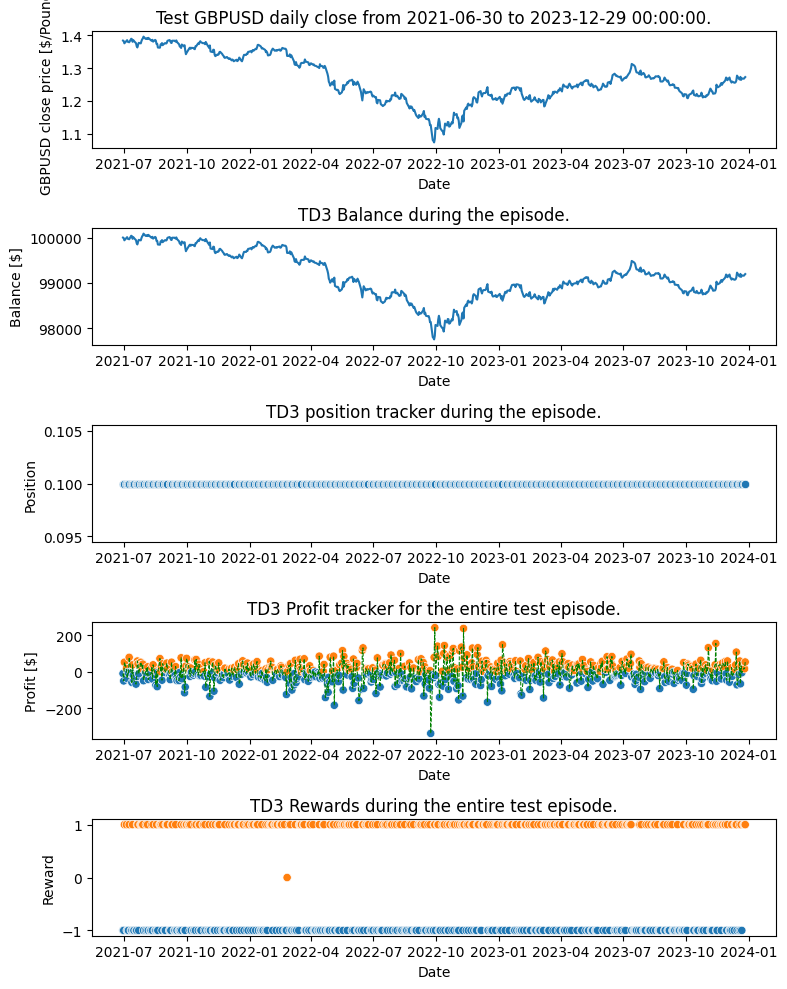

In [ ]:
fig, axs = plt.subplots(nrows=5, figsize=(8,10))

sns.lineplot(x=test_df.index[:-2], y=test_df['close'][:-2], ax=axs[0])
axs[0].set_title(f'Test GBPUSD daily close from {split_date} to {test_df.index[-1]}.')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('GBPUSD close price [$/Pound]')

sns.lineplot(x=test_df.index[:-2], y=td3_balance_tracker, ax=axs[1])
axs[1].set_title('TD3 Balance during the episode.')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Balance [$]')

sns.scatterplot(x=test_df.index[:-2], y=td3_position_tracker, ax=axs[2])
axs[2].set_title('TD3 position tracker during the episode.')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Position')

sns.lineplot(x=test_df.index[:-2], y=td3_episode_profit_tracker, ax=axs[3], ls='--', color='g', size=0.5, legend=False)
sns.scatterplot(x=test_df.index[:-2], y=td3_episode_profit_tracker, ax=axs[3], hue=[x>=0 for x in td3_episode_profit_tracker], legend=False)
axs[3].set_title('TD3 Profit tracker for the entire test episode.')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Profit [$]')


sns.scatterplot(x=test_df.index[:-2], y=td3_episode_reward_tracker, ax=axs[4], hue=[x>=0 for x in td3_episode_reward_tracker], legend=False)
axs[4].set_title('TD3 Rewards during the entire test episode.')
axs[4].set_xlabel('Date')
axs[4].set_ylabel('Reward')


plt.tight_layout()
plt.show()